# Ensembling

In [164]:
import math

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, HuberRegressor

import tensorflow.keras as tfk

import matplotlib.pyplot as plt

## The Data

### Load the preprocessed data

In [2]:
# !gsutil cp gs://franzfiles/full_data.csv .

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# cd '/content/gdrive/My Drive/Colab Notebooks/aiforsea'

In [5]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632


### Get info on the locations

In [6]:
locations = df['geohash6'].unique()

In [7]:
locations

array(['qp02yc', 'qp02z1', 'qp02z3', ..., 'qp0djw', 'qp0djy', 'qp0dnn'],
      dtype=object)

In [8]:
location_idx = {}
for i, location in enumerate(locations):
    location_idx[location] = i

In [36]:
%%time
gb = df.groupby('geohash6')    
location_series = {}
for x in gb.groups:
    group = gb.get_group(x).reset_index().drop('index', axis=1)
    location_series[x] = group

Wall time: 13.5 s


### Load the results

In [19]:
predictions      = np.load('predictions.npy')
actuals          = np.load('actuals.npy')
locations_subset = np.load('locations_subset.npy', allow_pickle=True)

In [20]:
print(predictions.shape, actuals.shape, locations_subset.shape)

(332, 20, 5, 5) (332, 20, 5) (332,)


In [21]:
TIMESTEPS = predictions.shape[1]
TIMESTEPS

20

### Load mahalanobis distances

In [ ]:
# mean_mahalanobis_dist = np.load('mean_mahalanobis_dist.npy')
# print(mean_mahalanobis_dist.shape)

In [12]:
freq_mahalanobis_dist = np.load('freq_mahalanobis_dist.npy')
print(freq_mahalanobis_dist.shape)

(1329,)


## Compare Errors

In [33]:
prev_mse_sum           = 0
kalman_mse_sum         = 0
y0_mse_sum             = 0
y2_mse_sum             = 0
fbm1_mse_sum           = 0
theta_mse_sum          = 0
theta_fb_mse_sum       = 0
all_naive_mse_sum      = 0
all_mse_sum            = 0

In [34]:
for i in range(len(predictions)):
    for t in range(TIMESTEPS):
        prev_mse_sum      += mean_squared_error(predictions[i][t][0], actuals[i][t])
        kalman_mse_sum    += mean_squared_error(predictions[i][t][1], actuals[i][t])
        y0_mse_sum        += mean_squared_error(predictions[i][t][2], actuals[i][t])
        y2_mse_sum        += mean_squared_error(predictions[i][t][3], actuals[i][t])
        fbm1_mse_sum      += mean_squared_error(predictions[i][t][4], actuals[i][t])
        
        theta_pred         = (predictions[i][t][2] + predictions[i][t][3]) / 2.0
        theta_fb_pred      = (theta_pred + predictions[i][t][4]) / 2.0
        all_naive_pred     = predictions[i][t].mean(axis=0)
        # all_pred           = (predictions[i][t][0] + predictions[i][t][1] + theta_pred + predictions[i][t][4]) / 4.0
        all_pred           = (predictions[i][t][1] + theta_pred + predictions[i][t][4]) / 3.0
        
        theta_pred         = np.clip(theta_pred    , a_min=0.0, a_max=1.0)
        theta_fb_pred      = np.clip(theta_fb_pred , a_min=0.0, a_max=1.0)
        all_naive_pred     = np.clip(all_naive_pred, a_min=0.0, a_max=1.0)
        all_pred           = np.clip(all_pred      , a_min=0.0, a_max=1.0)
        
        theta_mse_sum     += mean_squared_error(theta_pred, actuals[i][t])
        theta_fb_mse_sum  += mean_squared_error(theta_fb_pred, actuals[i][t])
        all_naive_mse_sum += mean_squared_error(all_naive_pred, actuals[i][t])
        all_mse_sum       += mean_squared_error(all_pred, actuals[i][t])

In [35]:
print("prev_rmse           ", math.sqrt(prev_mse_sum          /(TIMESTEPS * len(predictions))))
print("kalman_rmse         ", math.sqrt(kalman_mse_sum        /(TIMESTEPS * len(predictions))))
print("y0_rmse             ", math.sqrt(y0_mse_sum            /(TIMESTEPS * len(predictions))))
print("y2_rmse             ", math.sqrt(y2_mse_sum            /(TIMESTEPS * len(predictions))))
print("fbm1_rmse           ", math.sqrt(fbm1_mse_sum          /(TIMESTEPS * len(predictions))))
print("theta_rmse          ", math.sqrt(theta_mse_sum         /(TIMESTEPS * len(predictions))))
print("theta_fb_rmse       ", math.sqrt(theta_fb_mse_sum      /(TIMESTEPS * len(predictions))))
print("all_naive_rmse      ", math.sqrt(all_naive_mse_sum     /(TIMESTEPS * len(predictions))))
print("all_rmse            ", math.sqrt(all_mse_sum           /(TIMESTEPS * len(predictions))))

prev_rmse            0.053936077913443244
kalman_rmse          0.03900183400744959
y0_rmse              0.04821238328426944
y2_rmse              0.05208619646605197
fbm1_rmse            0.03973981575859182
theta_rmse           0.035792962736291206
theta_fb_rmse        0.033800964516169284
all_naive_rmse       0.03154250809608945
all_rmse             0.030120535060712182


## Compare Errors to Various Variables

In [25]:
Y_prev   = []
Y_kalman = []
Y_theta  = []
Y_fb     = []

for i in range(len(predictions)):
    prev_rmse   = 0
    kalman_rmse = 0
    theta_rmse  = 0
    fb_rmse     = 0
    for t in range(TIMESTEPS):
        theta_pred = (predictions[i][t][2] + predictions[i][t][3]) / 2.0
        theta_pred = np.clip(theta_pred    , a_min=0.0, a_max=1.0)
        
        prev_rmse   += mean_squared_error(predictions[i][t][0], actuals[i][t])
        kalman_rmse += mean_squared_error(predictions[i][t][1], actuals[i][t])
        theta_rmse  += mean_squared_error(theta_pred, actuals[i][t])
        fb_rmse     += mean_squared_error(predictions[i][t][4], actuals[i][t])
    
    prev_rmse   = math.sqrt(prev_rmse/TIMESTEPS)
    kalman_rmse = math.sqrt(kalman_rmse/TIMESTEPS)
    theta_rmse  = math.sqrt(theta_rmse/TIMESTEPS)
    fb_rmse     = math.sqrt(fb_rmse/TIMESTEPS)
    
    Y_prev.append([prev_rmse   ])
    Y_kalman.append([kalman_rmse ])
    Y_theta.append([theta_rmse  ])
    Y_fb.append([fb_rmse     ])

### Compare errors to the mahalanobis distance of the frequency

In [42]:
X_dist   = []

for i in range(len(predictions)):
    location = locations_subset[i]
    dist = freq_mahalanobis_dist[location_idx[location]]
    X_dist.append(dist)

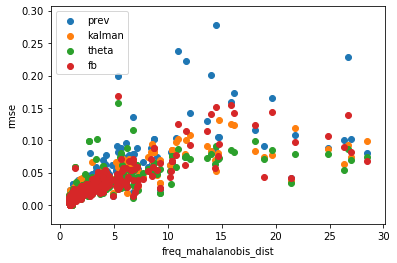

In [26]:
plt.scatter(X_dist, Y_prev, label='prev')
plt.scatter(X_dist, Y_kalman, label='kalman')
plt.scatter(X_dist, Y_theta, label='theta')
plt.scatter(X_dist, Y_fb, label='fb')
plt.legend()
plt.xlabel('freq_mahalanobis_dist')
plt.ylabel('rmse')
plt.show()

### Compare Errors to Demand Means

In [40]:
X_mean   = []

for i in range(len(predictions)):
    location = locations_subset[i]
    mean_ = location_series[location]['demand'].mean()
    X_mean.append(mean_)

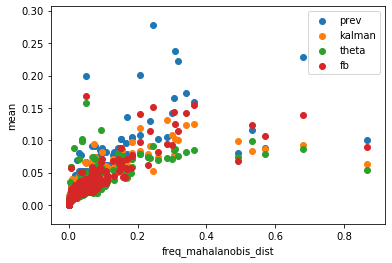

In [41]:
plt.scatter(X_mean, Y_prev, label='prev')
plt.scatter(X_mean, Y_kalman, label='kalman')
plt.scatter(X_mean, Y_theta, label='theta')
plt.scatter(X_mean, Y_fb, label='fb')
plt.legend()
plt.xlabel('freq_mahalanobis_dist')
plt.ylabel('mean')
plt.show()

### Compare errors to time of the day

In [49]:
X_time = np.arange(TIMESTEPS)
X_time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [46]:
Y_prev   = np.zeros(TIMESTEPS)
Y_kalman = np.zeros(TIMESTEPS)
Y_theta  = np.zeros(TIMESTEPS)
Y_fb     = np.zeros(TIMESTEPS)

for i in range(len(predictions)):
    for t in range(TIMESTEPS):
        theta_pred = (predictions[i][t][2] + predictions[i][t][3]) / 2.0
        theta_pred = np.clip(theta_pred    , a_min=0.0, a_max=1.0)
        
        Y_prev[t]   += mean_squared_error(predictions[i][t][0], actuals[i][t])
        Y_kalman[t] += mean_squared_error(predictions[i][t][1], actuals[i][t])
        Y_theta[t]  += mean_squared_error(theta_pred, actuals[i][t])
        Y_fb[t]     += mean_squared_error(predictions[i][t][4], actuals[i][t])

Y_prev   = np.sqrt(Y_prev   / len(predictions))
Y_kalman = np.sqrt(Y_kalman / len(predictions))
Y_theta  = np.sqrt(Y_theta  / len(predictions))
Y_fb     = np.sqrt(Y_fb     / len(predictions))

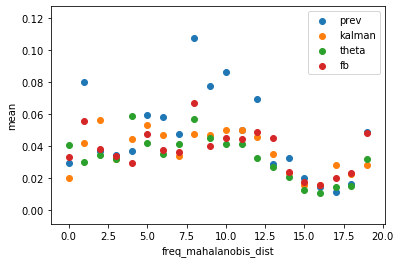

In [50]:
plt.scatter(X_time, Y_prev, label='prev')
plt.scatter(X_time, Y_kalman, label='kalman')
plt.scatter(X_time, Y_theta, label='theta')
plt.scatter(X_time, Y_fb, label='fb')
plt.legend()
plt.xlabel('freq_mahalanobis_dist')
plt.ylabel('mean')
plt.show()

## Linear Regression for the Weights

### Stage 1 (Kalman filter + Theta method)

In [171]:
predictions_ = predictions.transpose((0, 1, 3, 2)).reshape(-1, 5)
predictions_ = np.stack([predictions_[:,1], (predictions_[:,2] + predictions_[:,3])/2.0], axis=0)
predictions_ = predictions_.T
actuals_     = actuals.reshape(-1)

In [172]:
# lin_reg = LinearRegression(fit_intercept=False)
lin_reg = HuberRegressor(fit_intercept=False)
lin_reg = lin_reg.fit(predictions_, actuals_)

lin_reg.coef_

array([0.2969419 , 0.67783948])

### Stage 2 (Kalman filter + Theta method + FBProphet)

In [175]:
predictions_ = predictions.transpose((0, 1, 3, 2)).reshape(-1, 5)
predictions_ = np.stack([predictions_[:,1], (predictions_[:,2] + predictions_[:,3])/2.0, predictions_[:,4]], axis=0)
predictions_ = predictions_.T
actuals_     = actuals.reshape(-1)

In [176]:
# lin_reg = LinearRegression(fit_intercept=False)
lin_reg = HuberRegressor(fit_intercept=False)
lin_reg = lin_reg.fit(predictions_, actuals_)

lin_reg.coef_

array([0.309658  , 0.38132017, 0.29395973])

### Check

In [195]:
optimized_stage1_mse_sum = 0
optimized_stage2_mse_sum = 0

In [196]:
for i in range(len(predictions)):
    for t in range(TIMESTEPS):
        theta_pred         = (predictions[i][t][2] + predictions[i][t][3]) / 2.0
        
        optimized_stage1_pred = 0.2969419   * predictions[i][t][1] + \
                                0.67783948  * theta_pred
        
        optimized_stage2_pred = 0.309658   * predictions[i][t][1] + \
                                0.38132017 * theta_pred + \
                                0.29395973 * predictions[i][t][4]
        
        optimized_stage1_pred = np.clip(optimized_stage1_pred, a_min=0.0, a_max=1.0)
        optimized_stage2_pred = np.clip(optimized_stage2_pred, a_min=0.0, a_max=1.0)
        
        optimized_stage1_mse_sum += mean_squared_error(optimized_stage1_pred, actuals[i][t])
        optimized_stage2_mse_sum += mean_squared_error(optimized_stage2_pred, actuals[i][t])

In [197]:
print("all_rmse               ", math.sqrt(all_mse_sum              / (TIMESTEPS * len(predictions))))

print("optimized_stage1_rmse  ", math.sqrt(optimized_stage1_mse_sum / (TIMESTEPS * len(predictions))))
print("optimized_stage2_rmse  ", math.sqrt(optimized_stage2_mse_sum / (TIMESTEPS * len(predictions))))

all_rmse                0.030120535060712182
optimized_stage1_rmse   0.03202539470029315
optimized_stage2_rmse   0.030230689041774075


note the ~5% decrease of rmse from stage 1 to stage 2